In [16]:
import numpy as np
import matplotlib.pyplot as plt
import simim.siminterface as sim

tng100 = sim.SimHandler('TNG100-1')

rng = np.random.default_rng(1511)

pixel_size = tng100.box_edge_no_h / 450
z_for_modeling = 1.0
tng100_snap = tng100.get_snap_from_z(z_for_modeling)

bins = np.logspace(-3,3,21)
bin_centers = (bins[1:] + bins[:-1]) / 2
k = 2*np.pi * bin_centers

In [17]:
from simim import constants as sc
from simim.galprops import prop_behroozi_sfr, prop_delooze_cii

tng100.make_property(prop_behroozi_sfr, other_kws={'rng': rng}, overwrite=True, rename='sfr_behroozi', write=True)
tng100.make_property(prop_delooze_cii, other_kws={'rng': rng}, overwrite=True, rename='LCII', kw_remap={'sfr': 'sfr_behroozi'}, write=True)

d = tng100.cosmo.comoving_distance(z_for_modeling).value
yfactor = sc.c / sc.nu_cii * (1+z_for_modeling)**2 / (1000*tng100.cosmo.H(z_for_modeling).value)
dl = (1+z_for_modeling)*d    

conv = sc.Lsun_to_W / (4*np.pi*dl**2) * d**2 * yfactor / pixel_size**3 \
    * 1 / 3.0857e22**2 *1e26

grid_CII = tng100_snap.grid('LCII', res=pixel_size, norm=conv)

ps_CII = grid_CII.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_CII.spherical_average(ax=[0,1,2],shells=bins)
ps1d_CII = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

Assigning props for Snapshot 67.  
Assigning props for Snapshot 67.  


In [18]:
from simim.galprops import Prop
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as con


def I_HI(mass, redshift):
    if type(mass) == np.ndarray and mass.dtype != np.float64:
        mass = mass.astype(np.float64)
    z = redshift
    alp, beta = 0.09, -0.5 # dimensionless
    Om, Ob, h = cosmo.Om(z), cosmo.Ob(z), cosmo.h
    vc0 = 10 ** 1.56 * u.km / u.s
    Y_He = 0.24
    fHc = (1.0 - Y_He) * Ob / Om
    Delta_v = 18 * np.pi ** 2 + 82 * (Om - 1) - 39 * (Om - 1) ** 2 # dimensionless
    RvM = 46.1 * (Delta_v * Om * h ** 2 / 24.4) ** (-1/3) * ((1+z) / 3.3) ** -1 \
            * (mass / 1e11) ** (1/3) * u.kpc
    vcM = np.sqrt(con.G * mass * con.M_sun / RvM).to(u.km / u.s)
    vterm = np.exp(-1.0 * (vc0 / vcM) ** 3)
    massHI = alp * fHc * (mass / 1e11 / h) ** beta * vterm * mass * con.M_sun
    A10 = 2.869e-15 / u.s
    dl = cosmo.luminosity_distance(z).to(u.cm) * (1 + z)
    I_HI = 3 * con.h * con.c / (21 * u.cm) * A10 * massHI / (4 * np.pi * dl ** 2) / con.u / u.sr / u.Hz
    return I_HI.to(u.Jy / u.sr).value

prop_I_HI = Prop(prop_name='I_HI',
                 prop_function=I_HI,
                 kwargs=['mass', 'redshift'],
                 units="Jy/sr")

tng100.make_property(prop_I_HI, overwrite=True, write=True)

grid_HI = tng100_snap.grid('I_HI', res=pixel_size)

ps_HI = grid_HI.power_spectrum(in_place=False,normalize=True)

# Spherical average
_,ps1d = ps_HI.spherical_average(ax=[0,1,2],shells=bins)
ps1d_HI = ps1d[:,0] / np.prod(grid_HI.side_length)  # Normalize by volume

Assigning props for Snapshot 67.  


In [19]:
crossps = grid_CII.power_spectrum(cross_grid=grid_HI, in_place=False, normalize=True)

_,ps1d = crossps.spherical_average(ax=[0,1,2],shells=bins)
ps1d_cross = ps1d[:,0] / np.prod(grid_CII.side_length)  # Normalize by volume

In [ ]:
props_

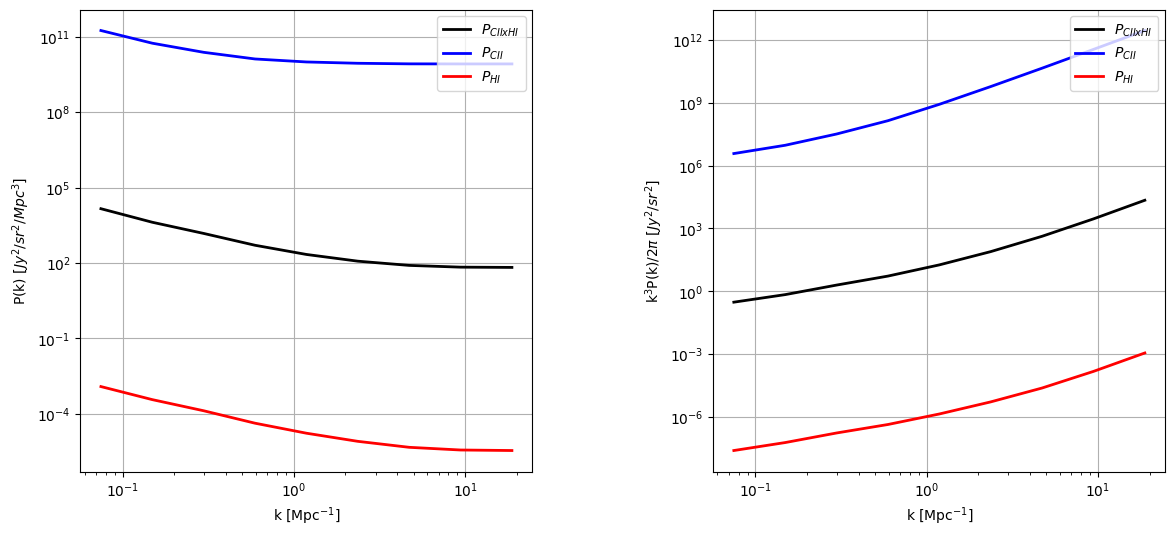

In [23]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_cross,lw=2,color='k', label='$P_{CII x HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_cross,lw=2,color='k', label='$P_{CII x HI}$')
ax[0].plot(k,ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_CII,lw=2,color='b', label='$P_{CII}$')
ax[0].plot(k,ps1d_HI,lw=2,color='r', label='$P_{HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_HI,lw=2,color='r', label='$P_{HI}$')


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()
plt.close()

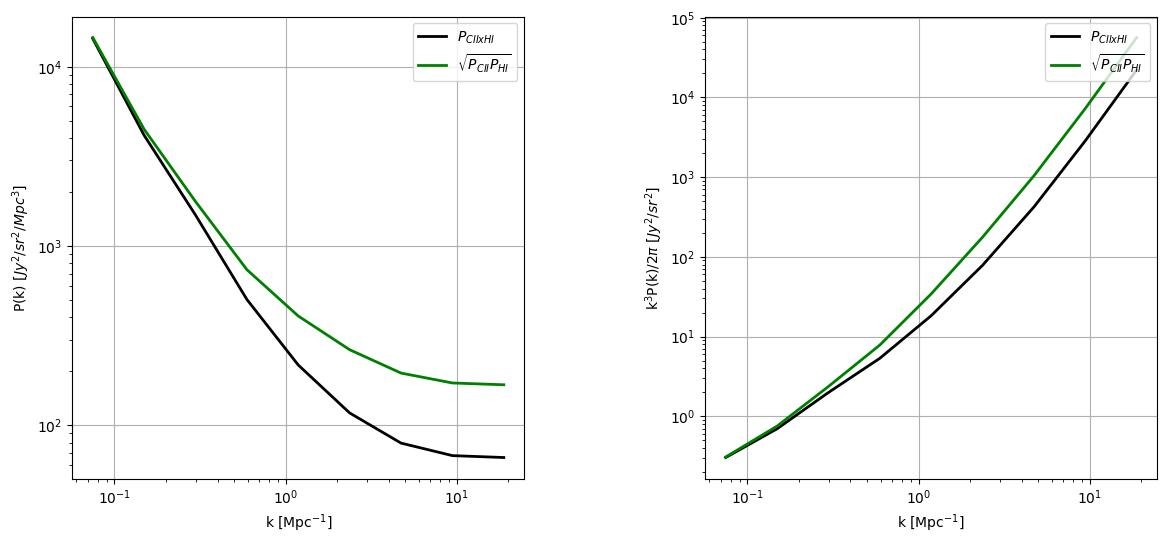

In [24]:
# Plot the results
fig,ax = plt.subplots(1,2,figsize=(14,6),sharex=True)
fig.subplots_adjust(wspace=.4)
ax[0].set(xlabel='k [Mpc$^{-1}$]',ylabel='P(k) [$Jy^2/sr^2/Mpc^3$]',xscale='log',yscale='log')
ax[0].grid()
ax[1].set(xlabel='k [Mpc$^{-1}$]',ylabel='k$^3$P(k)/2$\pi$ [$Jy^2/sr^2$]',xscale='log',yscale='log')
ax[1].grid()

ax[0].plot(k,ps1d_cross,lw=2,color='k', label='$P_{CII x HI}$')
ax[1].plot(k,k**3/2/np.pi**2*ps1d_cross,lw=2,color='k', label='$P_{CII x HI}$')
prod_ps = np.sqrt(ps1d_CII * ps1d_HI)
ax[0].plot(k,prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{HI}}$')
ax[1].plot(k,k**3/2/np.pi**2*prod_ps,lw=2,color='g', label='$\sqrt{P_{CII}P_{HI}}$')


ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.show()
plt.close()

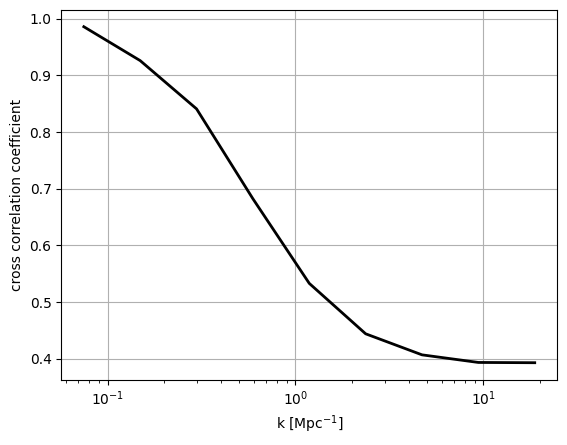

In [25]:
plt.figure()
plt.plot(k,ps1d_cross/prod_ps,lw=2,color='k')
plt.xscale('log')
plt.grid()
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel('cross correlation coefficient')
plt.show()
plt.close()

In [ ]:
from simim.lightcone import LCMaker, LCHandler

gen = LCMaker(sim='TNG100-1',
              name='cii_hi',
              openangle=1.0,
              aspect=1.0,
              mode = 'box',
              redshift_min = 0.5,
              redshift_max = 1.7,
              minimum_mass = 1e8)

gen.build_lightcones(rng=rng)
gen.add_properties('I_HI','LCII')

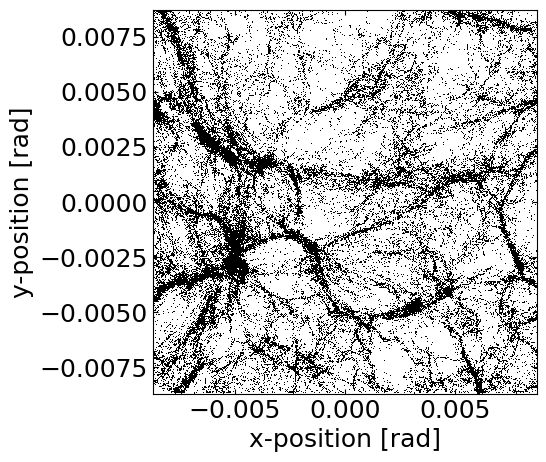

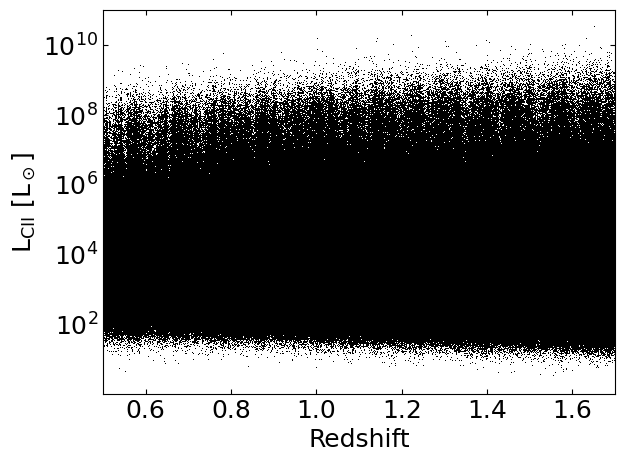

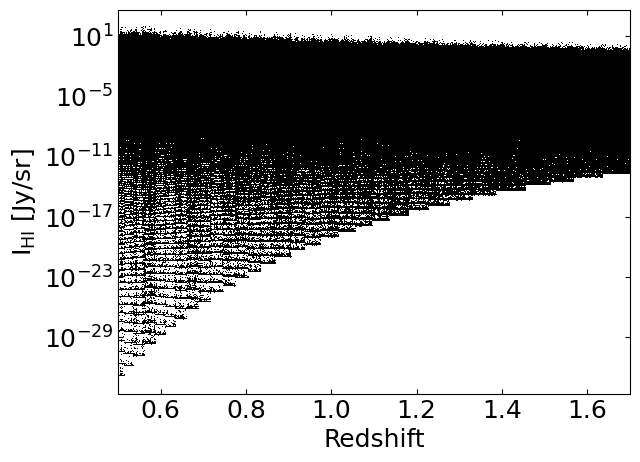

In [26]:
lc1 = LCHandler('TNG100-1','cii_hi',0)

lc1.set_property_range('redshift',0.999,1.001)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','LCII',
         axkws={'xlabel':'Redshift','ylabel':'L$_\mathregular{CII}$ [L$_\odot$]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range()
lc1.plot('redshift','I_HI',
         axkws={'xlabel':'Redshift','ylabel':'I$_\mathregular{HI}$ [Jy/sr]','xlim':(0.5,1.7),'yscale':'log'},
         plotkws={'marker':',','color':'k'})

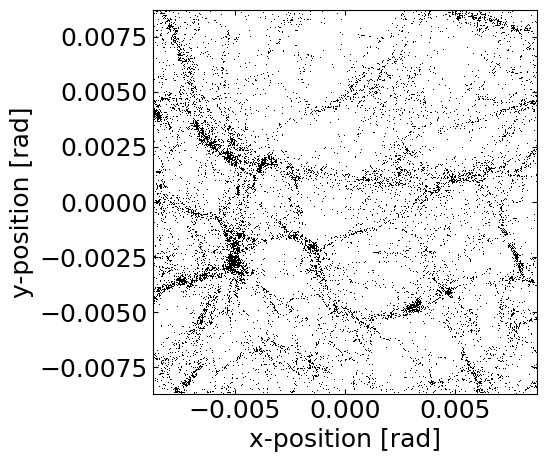

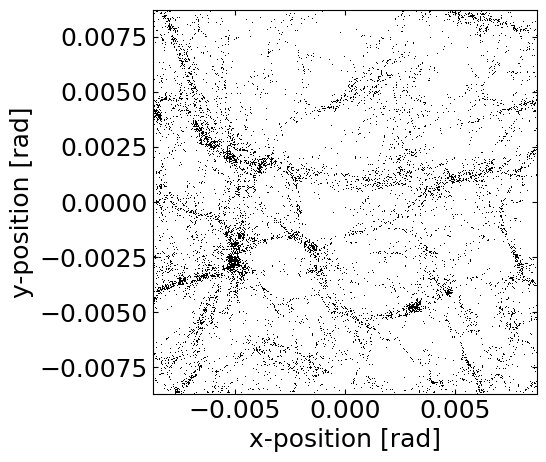

In [32]:
lc1.set_property_range("LCII", 1e4, 1e10)
lc1.set_property_range('redshift',0.999,1.001, reset=False)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})

lc1.set_property_range("I_HI", 1e-3, 1e5)
lc1.set_property_range('redshift',0.999,1.001, reset=False)
lc1.plot('ra','dec',
         axkws={'xlabel':'x-position [rad]','ylabel':'y-position [rad]','aspect':'equal','xlim':(-0.5*np.pi/180,0.5*np.pi/180),'ylim':(-0.5*np.pi/180,0.5*np.pi/180)},
         plotkws={'marker':',','color':'k'})